In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model
from tools.sampling import annealed_langevin_dynamic_sampler

In [3]:
# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=1.0):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# # Plot it
# data = sample_batch(10**5)
target = nf.distributions.CircularGaussianMixture()
data = target.sample(100000)

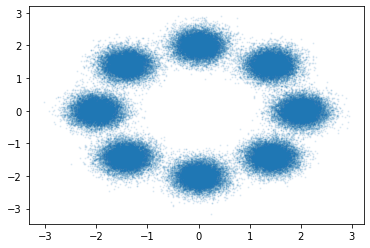

In [4]:
plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

In [5]:

ns=noise_scheduler(1e-3,0.2,100,schedule='sigmoid',var_norm=False)

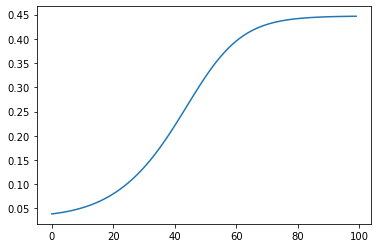

In [6]:
ns.plot_sigmas()

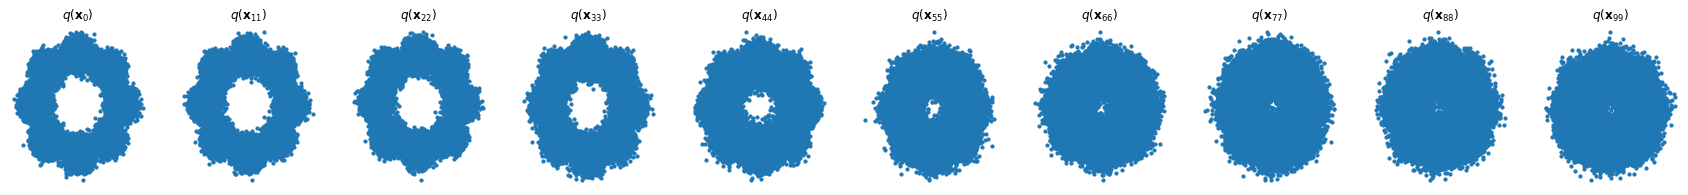

In [7]:
ns.visualize_noise(data)

In [8]:
# Our approximation model
model = score_model(ns.n_steps,2).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs=5000
batch = torch.tensor(data, dtype=torch.float32).to(device)
for epoch in range(epochs):
    # for batch in dataloader:

        # batch = batch[0].to(device)
        
    labels = torch.randint(0, ns.n_steps, (batch.shape[0],)).to(device)
    loss = anneal_dsm_score_estimation(model, batch, labels, ns)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if ((epoch % 1000) == 0):
        print(loss.item())

/tmp/ipykernel_2985473/2929289456.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data, dtype=torch.float32).to(device)


1.0143057107925415
0.7287667989730835
0.7148506045341492
0.7089608907699585
0.7063126564025879


(-3.0, 3.0)

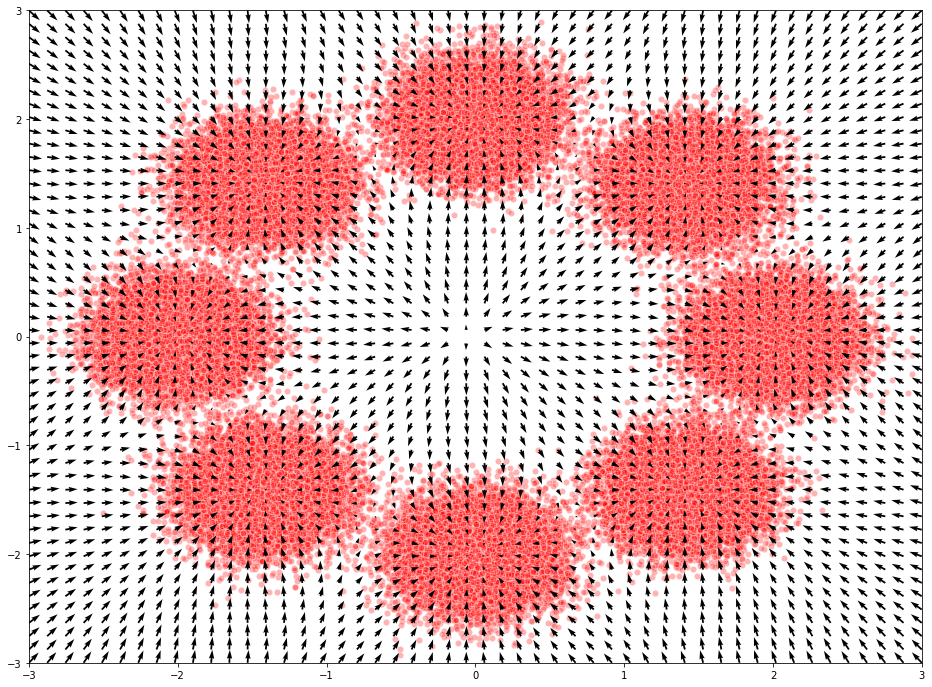

In [10]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*0
scores = model(torch.tensor(xx).float().to(device), labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [12]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

In [13]:
init_point=torch.randn(10000,2).to(device)*3.5-1.5
dynamic=sampler.sample(init_point)

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = dynamic[i * 10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

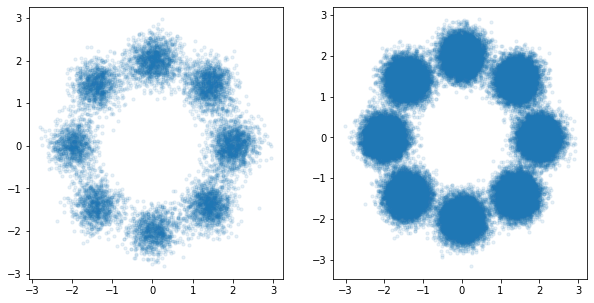

In [16]:

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(*dynamic[-1].cpu().numpy().T , s=10, alpha=0.1)
plt.subplot(122)
plt.scatter(*data.T , s=10, alpha=0.1)